# BSUD Project 2

# 1.Import Labraries: 

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from wordcloud import WordCloud
from textblob import TextBlob
import os
import nltk


# 2.Set Up Paths

In [52]:

data_folder = "../data"
reviews_path = os.path.join(data_folder, "tripadvisor_hotel_reviews.csv")
sentiment_path = os.path.join(data_folder, "tripadvisor_hotel_reviews_sentiment.csv")
target_sentiment_path = os.path.join(data_folder, "tripadvisor_hotel_reviews_target_sentiment.csv")
stopwords_path = os.path.join(data_folder, "Additional_Stopwords.txt")

import os

# Print each file path and check existence
print("Reviews path exists:", os.path.exists(reviews_path))
print("Sentiment path exists:", os.path.exists(sentiment_path))
print("Target sentiment path exists:", os.path.exists(target_sentiment_path))
print("Stopwords path exists:", os.path.exists(stopwords_path))



Reviews path exists: True
Sentiment path exists: True
Target sentiment path exists: True
Stopwords path exists: True


# 3.Load Data

In [44]:
# Load datasets
print(os.path.exists(stopwords_path))  # Should return True if the file exists

import os

# Check current working directory
print(os.getcwd())

# Replace 'absolute_path_to_data_folder' with the full path to your data folder
stopwords_path =os.path.join(data_folder, "Additional_Stopwords.txt")

# Load stopwords
try:
    with open(stopwords_path, "r") as file:
        additional_stopwords = file.read().splitlines()
    print("Stopwords loaded successfully!")
except Exception as e:
    print(f"Error loading stopwords: {e}")



True
/Users/muhi/PycharmProjects/scientificProject/models
Stopwords loaded successfully!


# 4.Preprocessing

In [72]:
# Combine NLTK stopwords with additional stopwords
nltk_stopwords = set(stopwords.words("english"))
combined_stopwords = nltk_stopwords.union(set(additional_stopwords))

lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in combined_stopwords]
    return " ".join(tokens)

# Apply preprocessing
reviews["processed_text"] = reviews["Review"].apply(preprocess)
reviews.head()
# Aspect Extraction (Add below existing preprocessing code)
aspects = {
    "service": ["service", "staff", "helpful"],
    "location": ["location", "area", "nearby"],
    "cleanliness": ["clean", "dirty", "tidy"]
}

def extract_aspects(text):
    for aspect, keywords in aspects.items():
        if any(keyword in text for keyword in keywords):
            return aspect
    return "other"

# Add aspect extraction to the dataset
reviews["aspect"] = reviews["processed_text"].apply(extract_aspects)



# 5.Sentiment Analysis

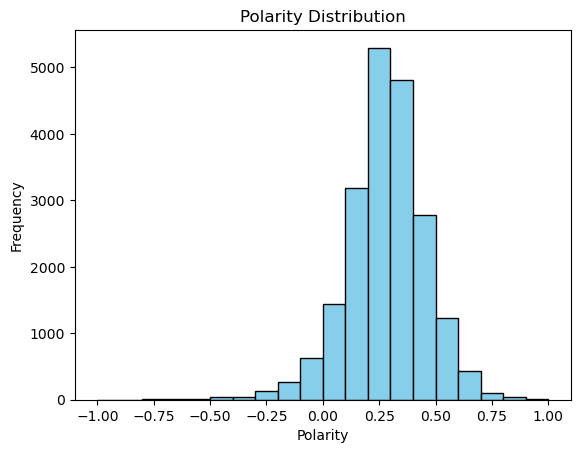

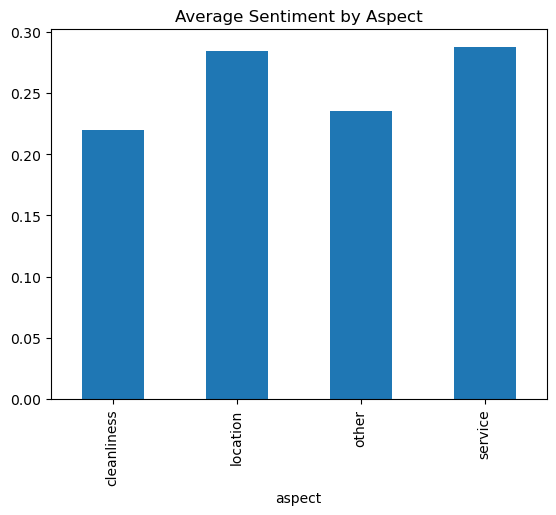

In [99]:
# Sentiment analysis with TextBlob
reviews["polarity"] = reviews["processed_text"].apply(lambda x: TextBlob(x).sentiment.polarity)
reviews["subjectivity"] = reviews["processed_text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Visualize sentiment polarity distribution
plt.hist(reviews["polarity"], bins=20, color="skyblue", edgecolor="black")
plt.title("Polarity Distribution")
plt.xlabel("Polarity")
plt.ylabel("Frequency")
plt.show()
# Recreate the polarity column
reviews["polarity"] = reviews["processed_text"].apply(lambda x: TextBlob(x).sentiment.polarity)

# Aspect-Based Sentiment Analysis
reviews["aspect_sentiment"] = reviews["processed_text"].apply(lambda x: TextBlob(x).sentiment.polarity)

# Summarize sentiment by aspect
aspect_summary = reviews.groupby("aspect")["aspect_sentiment"].mean()
aspect_summary.plot(kind="bar", title="Average Sentiment by Aspect")
plt.show()



# 6.Sentiment Analysis by Aspect

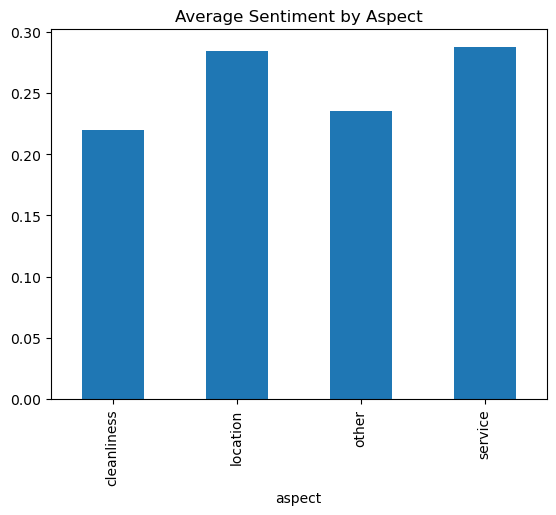

ModuleNotFoundError: No module named 'sentence_transformers'

In [86]:
aspects = {
    "service": ["service", "staff", "helpful"],
    "location": ["location", "area", "nearby"],
    "cleanliness": ["clean", "dirty", "tidy"]
}

def extract_aspects(text):
    for aspect, keywords in aspects.items():
        if any(keyword in text for keyword in keywords):
            return aspect
    return "other"

reviews["aspect"] = reviews["processed_text"].apply(extract_aspects)
reviews["aspect_sentiment"] = reviews["processed_text"].apply(lambda x: TextBlob(x).sentiment.polarity)

aspect_summary = reviews.groupby("aspect")["aspect_sentiment"].mean()
aspect_summary.plot(kind="bar", title="Average Sentiment by Aspect")
plt.show()




# 7.Topic Modelling

Loaded 20491 reviews.
Text preprocessing complete.
TF-IDF matrix shape: (20491, 1000)
LDA model fitted.
Topic 1:
small, bed, night, good, location, stay, nice, great, hotel, room
Topic 2:
staff, manager, day, night, stay, desk, service, told, room, hotel
Topic 3:
room, people, good, day, great, time, pool, food, beach, resort
Topic 4:
service, good, excellent, stayed, staff, stay, location, great, room, hotel
Topic 5:
station, staff, clean, walk, breakfast, good, location, great, room, hotel


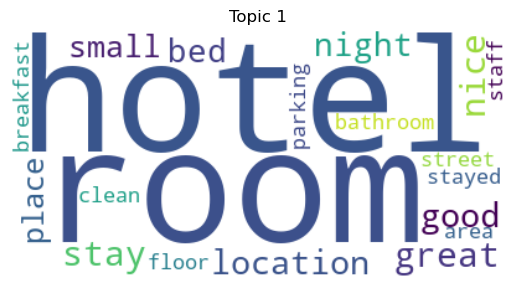

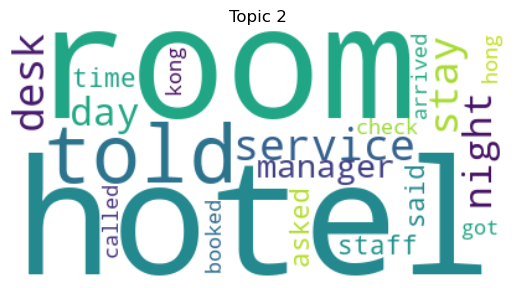

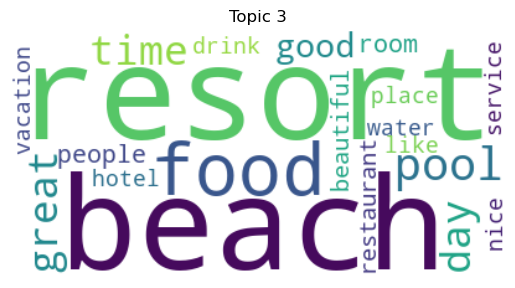

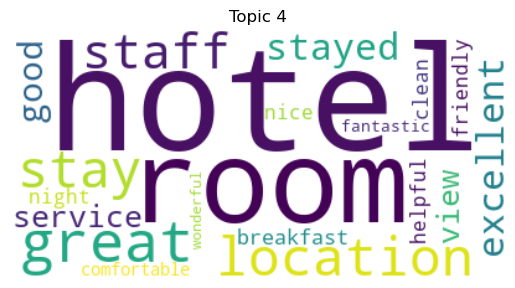

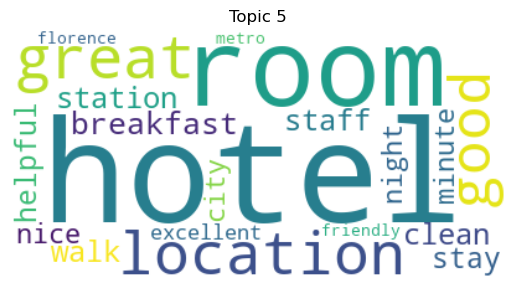

In [85]:

data_folder = "../data"
reviews_path = f"{data_folder}/tripadvisor_hotel_reviews.csv"

reviews = pd.read_csv(reviews_path)

# Ensure there is a 'Review' column in your dataset
if 'Review' not in reviews.columns:
    raise ValueError("Dataset must contain a 'Review' column.")

print(f"Loaded {len(reviews)} reviews.")
# Define preprocessing function
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    if pd.isnull(text):
        return ""
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    return " ".join(tokens)

# Apply preprocessing to reviews
reviews["processed_text"] = reviews["Review"].apply(preprocess)
print("Text preprocessing complete.")
# Create TF-IDF features
vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
X = vectorizer.fit_transform(reviews["processed_text"])

print(f"TF-IDF matrix shape: {X.shape}")
# Fit LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # Set 5 topics
lda.fit(X)

print("LDA model fitted.")
# Display topics and their top words
num_words = 10  # Number of words to display per topic

for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx + 1}:")
    print(", ".join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-num_words:]]))
# Generate and display word clouds for topics
for idx, topic in enumerate(lda.components_):
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(
        {vectorizer.get_feature_names_out()[i]: topic[i] for i in topic.argsort()[-20:]}
    )
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {idx + 1}")
    plt.show()



# 8.Interactive Topic Modelling

In [84]:
import pyLDAvis

# Enable notebook visualization
pyLDAvis.enable_notebook()

# Extract term frequency and vocabulary
vocab = vectorizer.get_feature_names_out()
term_frequency = X.sum(axis=0).A1  # Sum the term frequencies across all documents

# Prepare the visualization using the updated pyLDAvis interface
panel = pyLDAvis.prepare(
    topic_term_dists=lda.components_,
    doc_topic_dists=lda.transform(X),
    doc_lengths=[len(doc.split()) for doc in reviews["processed_text"]],
    vocab=vocab,
    term_frequency=term_frequency
)

# Display the panel
pyLDAvis.display(panel)


# 9.Clustering  

/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


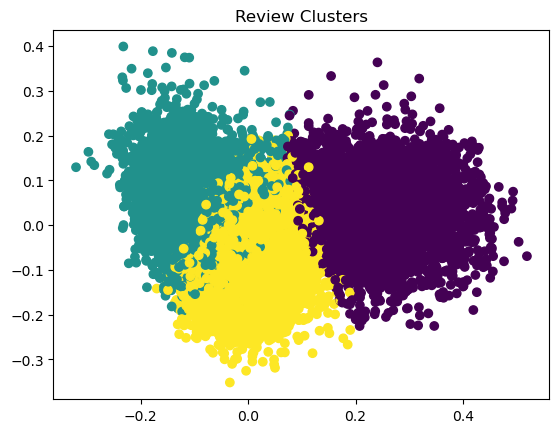

In [118]:
kmeans = KMeans(n_clusters=3, random_state=42)
reviews["cluster"] = kmeans.fit_predict(X)

# Visualize clusters
reduced_features = PCA(n_components=2).fit_transform(X.toarray())
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=reviews["cluster"], cmap="viridis")
plt.title("Review Clusters")
plt.show()



# 10.Generate Insights

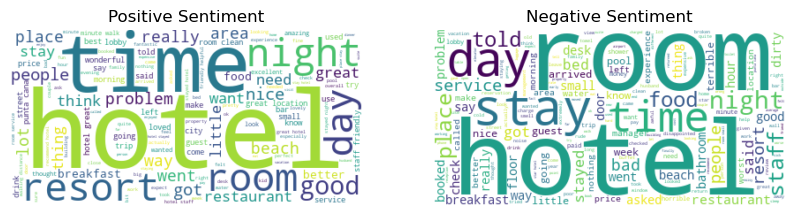

                                                 Review  polarity
9715  basic nice, basic hotel clean tidy, did n't th...  0.363095
9678  excellent staff small room staff nadia hotel n...  0.358333
4798  efficient friendly staff areas hotel clean mod...  0.445000
9611  just perfect, experience better expected, room...  0.313021
8590  clean room staff friendly helpful, communal ar...  0.330128


In [119]:
# Generate positive and negative reviews text
positive_reviews = " ".join(reviews[reviews["polarity"] > 0]["processed_text"])
negative_reviews = " ".join(reviews[reviews["polarity"] < 0]["processed_text"])

# Generate word clouds
positive_wc = WordCloud(background_color="white").generate(positive_reviews)
negative_wc = WordCloud(background_color="white").generate(negative_reviews)

# Display word clouds
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(positive_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Sentiment")

plt.subplot(1, 2, 2)
plt.imshow(negative_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Sentiment")

plt.show()

# Semantic Search (if embeddings are still intact)
query_result = semantic_search("clean rooms with friendly staff")
print(query_result[["Review", "polarity"]])



# 11.Semantic Search 

In [114]:
from sentence_transformers import SentenceTransformer, util


# Load the SentenceTransformer model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Generate embeddings for all processed reviews
embeddings = model.encode(reviews["processed_text"].tolist(), show_progress_bar=True)

# Verify that embeddings have been generated
print(f"Generated {len(embeddings)} embeddings.")

def semantic_search(query, k=5):
    """
    Perform semantic search to find the top-k most similar reviews to the query.
    
    Args:
        query (str): The search query.
        k (int): Number of top results to return.
    
    Returns:
        DataFrame: Top-k similar reviews with their scores.
    """
    # Encode the query
    query_embedding = model.encode([query])

    # Compute cosine similarity between the query and all embeddings
    scores = util.cos_sim(query_embedding, embeddings)[0]

    # Get the indices of the top-k highest scores
    top_indices = scores.argsort(descending=True)[:k]

    # Return the top-k reviews with scores
    results = reviews.iloc[top_indices].copy()
    results["score"] = scores[top_indices].tolist()
    return results

# Example query
query = "clean rooms with friendly staff"
query_results = semantic_search(query, k=5)

# Display the results
print(query_results[["Review", "polarity", "score"]])


Batches:   0%|          | 0/641 [00:00<?, ?it/s]

Generated 20491 embeddings.
                                                 Review  polarity     score
9715  basic nice, basic hotel clean tidy, did n't th...  0.363095  0.725153
9678  excellent staff small room staff nadia hotel n...  0.358333  0.715506
4798  efficient friendly staff areas hotel clean mod...  0.445000  0.674998
9611  just perfect, experience better expected, room...  0.313021  0.668927
8590  clean room staff friendly helpful, communal ar...  0.330128  0.666529


# 12.Save Results

In [50]:
reviews.to_csv(os.path.join(data_folder, "processed_reviews.csv"), index=False)
